In [22]:
ban='_1637078222.629906_8_0.8196_0.664'
batch_size=8

In [2]:
import torch

device0 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")
device1 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")

In [3]:
# 读数据
import pandas as pd
df_train=pd.read_excel("../data/df_train.xlsx",index_col=0)
df_test=pd.read_excel("../data/df_test.xlsx",index_col=0)

In [4]:
import ast
for i in range(len(df_train)):
    old_list=ast.literal_eval(df_train.loc[i]['label'])
    df_train.loc[i]['label']=old_list
    
for i in range(len(df_test)):
    old_list=ast.literal_eval(df_test.loc[i]['label'])
    df_test.loc[i]['label']=old_list

In [5]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
df_train_text=[df_train['text'][i] for i in range(len(df_train))]
df_test_text=[df_test['text'][i] for i in range(len(df_test))]


In [6]:
text2id_train = tokenizer(
        df_train_text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
input_ids_train=text2id_train["input_ids"]
mask_train=text2id_train["attention_mask"]

text2id_test = tokenizer(
        df_test_text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
input_ids_test=text2id_test["input_ids"]
mask_test=text2id_test["attention_mask"]


In [7]:
df_train['input_ids']=input_ids_train.tolist()
df_train['mask']=mask_train.tolist()

df_test['input_ids']=input_ids_test.tolist()
df_test['mask']=mask_test.tolist()

In [8]:
from torch.utils.data import Dataset
class SentimentDataset(Dataset):
    def __init__(self,df):
        self.dataset = df
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, "text"]
        label = self.dataset.loc[idx, "label"]
#         print(label)
        input_ids = self.dataset.loc[idx, "input_ids"]
        mask = self.dataset.loc[idx, "mask"]
        sample = {"text": text, "label": label,"input_ids":input_ids,"mask":mask}
        # print(sample)
        return sample

In [9]:
#按batch_size分
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import torch

train_loader = DataLoader(
    SentimentDataset(df_train), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)
print(train_loader)

test_loader = DataLoader(
    SentimentDataset(df_test), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)
print(test_loader)

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F


class fn_cls(nn.Module):
    def __init__(self,device):
        super(fn_cls, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-chinese")
        self.model.to(device)
        self.dropout = nn.Dropout(0.5)
        self.l1 = nn.Linear(768, 24)
        
        
    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
        x = outputs[1]
        x = self.dropout(x)
        x = self.l1(x)#8 24
        end=[]
        for i in range(len(x)):
            end.append(torch.stack(list(x[i].split(4, 0))))
        x=torch.stack(end)
#         print(x)
        return x #batchsize* 6 * 4

In [23]:
import torch

if ban==0:
    cls = fn_cls(device0)
    cls.train()
else:
    cls=torch.load("../data/cls"+str(ban)+".model",map_location=device0)

In [12]:
import numpy as np
sumn=np.zeros((6,4))
for i in range(len(df_train)):
    label=df_train.loc[i]['label']
    for j in range(6):
        sumn[j][label[j]]+=1
# print(sumn)
sumn=sumn.tolist()
# print(sumn)
sumn0=np.zeros((6,4))
for i in range(6):
    print(sumn[i])
    for j in range(4):
        sumn0[i][j]=sumn[i][0]/sumn[i][j]
# print(sumn0)
sumn0=torch.tensor(sumn0).float().to(device0)
# print(sumn0)


[28970.0, 410.0, 314.0, 408.0]
[28234.0, 1222.0, 425.0, 221.0]
[28536.0, 814.0, 472.0, 280.0]
[27108.0, 1405.0, 1045.0, 544.0]
[27972.0, 928.0, 824.0, 378.0]
[25519.0, 1945.0, 1706.0, 932.0]


In [13]:
print(sumn0)

tensor([[  1.0000,  70.6585,  92.2611,  71.0049],
        [  1.0000,  23.1047,  66.4329, 127.7557],
        [  1.0000,  35.0565,  60.4576, 101.9143],
        [  1.0000,  19.2940,  25.9407,  49.8309],
        [  1.0000,  30.1422,  33.9466,  74.0000],
        [  1.0000,  13.1203,  14.9584,  27.3809]], device='cuda:5')


In [26]:
from torch import optim
#BCEWithLogitsLoss就是把Sigmoid-BCELoss合成一步
criterion=[]
for i in range(6):
    criterion.append(nn.CrossEntropyLoss(weight=sumn0[i]))
# for i in range(6):
#     criterion.append(nn.CrossEntropyLoss())
Softmax=nn.Softmax(dim = 2) 
optimizer = optim.Adam(cls.parameters(), lr=1e-6)

In [20]:
def get_loss_test(output,A):#8*18
#     print(output,A)
    cor_add=(output == A).sum().item()
    sum0=0
    for i in range(len(output)):
        for j in range(6):
            sum0+=(output[i][j]-A[i][j])*(output[i][j]-A[i][j])
#     print(sum0.item(),cor_add)
    return sum0.item(),cor_add

def test(device_test):
    cls.to(device_test)
    cls.eval()

    correct = 0
    total = 0
    loss_test=0
    loss_aa=0
    for batch_idx,batch in enumerate(test_loader):
        with torch.no_grad():
            label_=torch.stack(batch['label']).long().to(device_test)#用于算loss
            input_ids=torch.stack(batch['input_ids']).t().to(device_test)
            mask=torch.stack(batch['mask']).t().to(device_test)
            output = cls(input_ids, attention_mask=mask)

            #计算loss
            output_=torch.transpose(output,0,1)#用于算loss
            loss_a=0
            for i in range(6):
#                 print(output_[i],label_[i])
                loss=criterion[i](output_[i],label_[i])
                loss_a+=loss
            loss_aa+=loss_a.item()
            
            
            #计算score和acc
            label=label_.t().to(device_test)#用于算分
            output=Softmax(output)
            output=output.argmax(dim=2)
            
            total += len(output)*6
            
            loss_add,cor_add = get_loss_test(output, label)
            loss_test+=loss_add
            correct+=cor_add
            tes_score=1/(1+(loss_test/total) ** 0.5)
            acc_score=100.*correct/total
   
        

        print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，score：{}，loss：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc_score,
                    tes_score,loss_aa
            ),end='\r')
    print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，score：{}，loss：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc_score,
                    tes_score,loss_aa
            ))
#     cls.to(device_train)
    return tes_score,acc_score

# test(device1)

_________________________________________________________________
_________________________________________________________________
_________________ epoch:9 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 0],ore:0.846050	准确率：98.97%	loss：1443.5111921355128
        [0, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], device='cuda:5')
pred: tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], device='cuda:5')


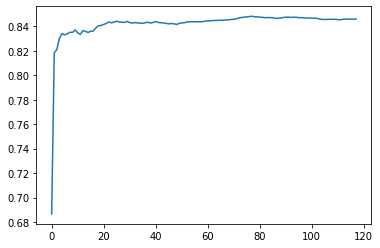

Train Epoch: 9	score:0.846030	准确率：98.97%	loss：1450.1800920292735
[834/835 (100%)]	正确分类的样本数：35045，样本总数：40080，准确率：87.44%，score：0.6710974614438758，loss：8099.233661487699
epoch: 9_执行时间:  237.93076920509338
_________________________________________________________________
_________________________________________________________________
_________________ epoch:9 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:10 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 0],core:0.851666	准确率：99.05%	loss：1352.0380343478173
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 2],
   

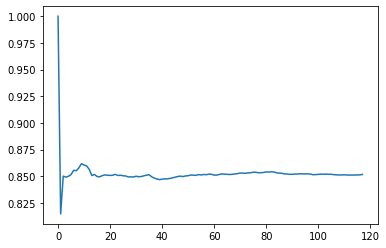

Train Epoch: 10	score:0.851826	准确率：99.05%	loss：1359.9871659446508
[834/835 (100%)]	正确分类的样本数：35044，样本总数：40080，准确率：87.44%，score：0.6710974614438758，loss：8174.819709695876
epoch: 10_执行时间:  238.05076503753662
_________________________________________________________________
_________________________________________________________________
_________________ epoch:10 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:11 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 1],core:0.857725	准确率：99.13%	loss：1270.7540851561353
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],


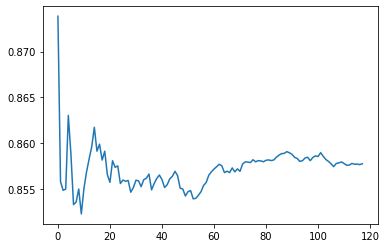

Train Epoch: 11	score:0.857853	准确率：99.13%	loss：1275.1388935772702
[834/835 (100%)]	正确分类的样本数：35069，样本总数：40080，准确率：87.50%，score：0.672480285082693，loss：8236.1173767298461
epoch: 11_执行时间:  238.92706775665283
_________________________________________________________________
_________________________________________________________________
_________________ epoch:11 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:12 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 1, 0, 0, 0, 0],core:0.860657	准确率：99.17%	loss：1217.3014658447355
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],


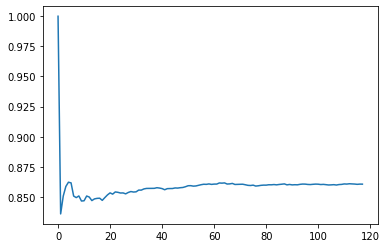

Train Epoch: 12	score:0.860838	准确率：99.17%	loss：1222.3468984197825
[834/835 (100%)]	正确分类的样本数：35075，样本总数：40080，准确率：87.51%，score：0.6720754754044295，loss：8333.427246477455
epoch: 12_执行时间:  238.31474018096924
_________________________________________________________________
_________________________________________________________________
_________________ epoch:12 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:13 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 2, 3],core:0.865797	准确率：99.22%	loss：1153.7954449709505
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 2, 0],


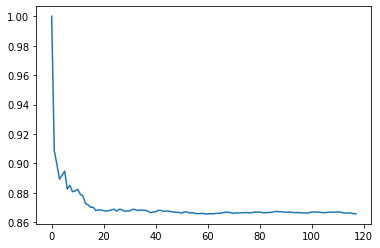

Train Epoch: 13	score:0.865884	准确率：99.22%	loss：1158.567714607343
[834/835 (100%)]	正确分类的样本数：35097，样本总数：40080，准确率：87.57%，score：0.6729211914657343，loss：8432.818562224507
epoch: 13_执行时间:  238.43008279800415
_________________________________________________________________
_________________________________________________________________
_________________ epoch:13 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:14 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 0],core:0.869294	准确率：99.26%	loss：1114.3794565098368
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 3],
 

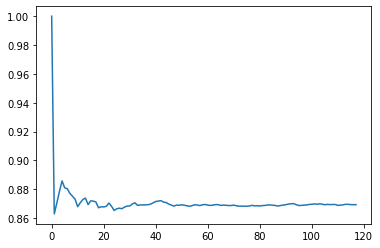

Train Epoch: 14	score:0.869423	准确率：99.26%	loss：1121.1654018135741
[834/835 (100%)]	正确分类的样本数：35102，样本总数：40080，准确率：87.58%，score：0.6730839996427251，loss：8505.494797978555
epoch: 14_执行时间:  237.49704957008362
_________________________________________________________________
_________________________________________________________________
_________________ epoch:14 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:15 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 1],core:0.873135	准确率：99.30%	loss：1061.5510680880398
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0],


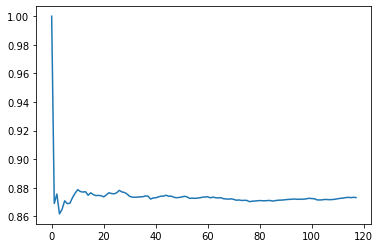

Train Epoch: 15	score:0.873193	准确率：99.30%	loss：1066.5246545504779
[834/835 (100%)]	正确分类的样本数：35107，样本总数：40080，准确率：87.59%，score：0.6736203478958008，loss：8615.509257578291
epoch: 15_执行时间:  238.06769728660583
_________________________________________________________________
_________________________________________________________________
_________________ epoch:15 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:16 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 0],core:0.875427	准确率：99.33%	loss：1016.9285397846252
        [0, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],


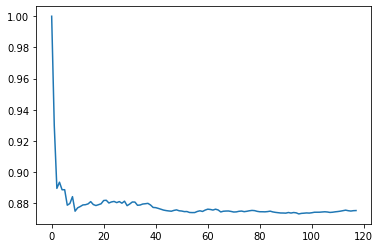

Train Epoch: 16	score:0.875401	准确率：99.33%	loss：1020.8646560553461
[834/835 (100%)]	正确分类的样本数：35117，样本总数：40080，准确率：87.62%，score：0.6740064559910265，loss：8671.876813215204
epoch: 16_执行时间:  237.27329230308533
_________________________________________________________________
_________________________________________________________________
_________________ epoch:16 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:17 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 0, 0, 0],core:0.879193	准确率：99.37%	loss：983.86523327045144
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0],


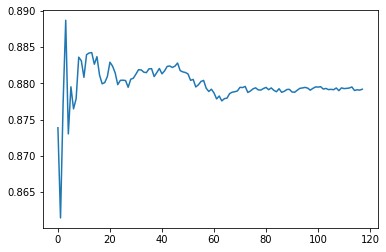

Train Epoch: 17	score:0.879444	准确率：99.37%	loss：986.5549084674567
[834/835 (100%)]	正确分类的样本数：35131，样本总数：40080，准确率：87.65%，score：0.6744877327340145，loss：8772.597381105646
epoch: 17_执行时间:  237.0792999267578
_________________________________________________________________
_________________________________________________________________
_________________ epoch:17 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:18 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0, 0, 0, 3, 0, 0],core:0.881637	准确率：99.39%	loss：941.63588164094845
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0],
  

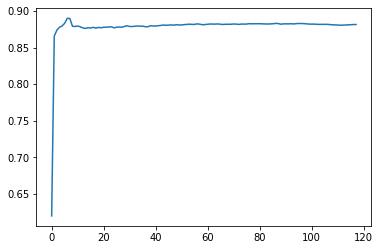

Train Epoch: 18	score:0.881323	准确率：99.39%	loss：947.5914064431563
[834/835 (100%)]	正确分类的样本数：35137，样本总数：40080，准确率：87.67%，score：0.6746760215449185，loss：8846.860437428579
epoch: 18_执行时间:  237.45418429374695
_________________________________________________________________
_________________________________________________________________
_________________ epoch:18 end _________________
_________________________________________________________________
_________________________________________________________________


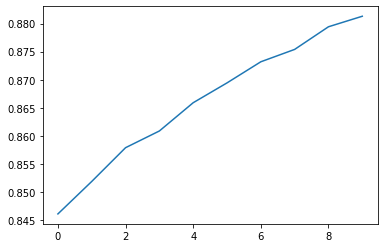

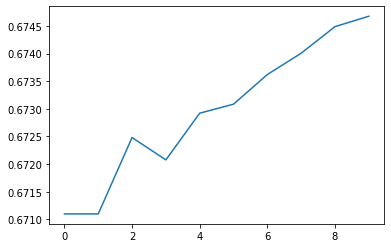

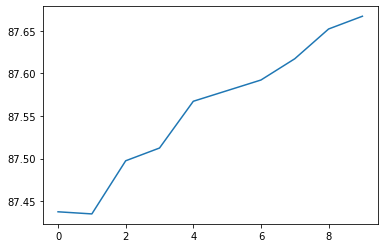

In [27]:
import time  # 引入time模块
 

import torch
import matplotlib.pyplot as plt

def train(device_train,device_test,epoch_be=0):
    epoch_num=10
    accumulation_steps=32
    
    train_score=[]
    test_score=[]
    test_acc=[]
    
    
    for epoch_idx in range(epoch_be,epoch_be+epoch_num):
        print("_________________________________________________________________")
        print("_________________________________________________________________")
        print("_________________ epoch:"+str(epoch_idx)+" start _________________")
        print("_________________________________________________________________")
        print("_________________________________________________________________")
        cls.to(device_train)
        score_list=[]
        
        loss_aa=0
        loss_train=0
        total=0
        correct=0
        start = time.time()
        for batch_idx,batch in enumerate(train_loader):
            label_=torch.stack(batch['label']).long().to(device_train)#用于算loss
            input_ids=torch.stack(batch['input_ids']).t().to(device_train)
            mask=torch.stack(batch['mask']).t().to(device_train)
            output = cls(input_ids, attention_mask=mask)
#             print(output)
            #计算loss
            output_=torch.transpose(output,0,1)#用于算loss
            loss_a=0
            for i in range(6):
#                 print(output_[i],label_[i])
                loss=criterion[i](output_[i],label_[i])
#                 print(loss)
                loss_a+=loss
            loss_a = loss_a/accumulation_steps
            loss_a.backward()
            
            #计算score和acc
            with torch.no_grad():
                loss_aa+=loss_a.item()*accumulation_steps
                
                label=label_.t().to(device_train)#用于算分
#                 print(output)
                output=Softmax(output)
#                 print(output)
                output=output.argmax(dim=2)
#                 print(output)
                total += len(output)*6

                loss_add,cor_add = get_loss_test(output, label)
                loss_train+=loss_add
                correct+=cor_add
                tr_score=1/(1+(loss_train/total) ** 0.5)
                acc_score=100.*correct/total


            if((batch_idx+1) % accumulation_steps) == 0:
                # 每 accumulation_steps 次更新一下网络中的参数
                optimizer.step()
                optimizer.zero_grad()

            if ((batch_idx+1) % accumulation_steps) == 1:
                score_list.append(tr_score)
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tscore:{:.6f}\t准确率：{:.2f}%\tloss：{}'.format(
                    epoch_idx, batch_idx, len(train_loader), 
                    100.*batch_idx/len(train_loader), tr_score,acc_score,loss_aa
                ),end='\r')
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tscore:{:.6f}\t准确率：{:.2f}%\tloss：{}'.format(
#                     epoch_idx, batch_idx, len(train_loader), 
#                     100.*batch_idx/len(train_loader), tr_score,acc_score,loss_aa
#                 ))

        #每个epoch结束：
        print('labels:', label)
        print('pred:', output)
        plt.plot([i for i in range(len(score_list))], score_list)
        plt.show()

        print('Train Epoch: {}\tscore:{:.6f}\t准确率：{:.2f}%\tloss：{}'.format(epoch_idx,tr_score,acc_score,loss_aa))
        t_score,t_acc=test(device_test)

        train_score.append(tr_score)
        test_score.append(t_score)
        test_acc.append(t_acc)

        #保存模型
        end = time.time()
        print('epoch:',str(epoch_idx)+'_执行时间: ',end - start)
        torch.save(cls,"../data/cls_"+str(end)+"_"+str(epoch_idx)+"_"+str(round(tr_score,4))+"_"+str(round(t_score,4))+".model")

        print("_________________________________________________________________")
        print("_________________________________________________________________")
        print("_________________ epoch:"+str(epoch_idx)+" end _________________")
        print("_________________________________________________________________")
        print("_________________________________________________________________")

    plt.plot([i for i in range(len(train_score))], train_score)
    plt.show()

    plt.plot([i for i in range(len(test_score))], test_score)
    plt.show()

    plt.plot([i for i in range(len(test_acc))], test_acc)
    plt.show()
    
train(device0,device1,epoch_be=9)


In [31]:
end = time.time()
torch.save(cls,"../data/cls_"+str(end)+"_"+str(2)+"_"+str(0.6886)+"_"+str(0.6942)+".model")


In [24]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

def get_output(device_pre,model,text,f=0):
    model.to(device_pre)
    model.eval()
    text2id = tokenizer(
        text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
#     print(text,text2id)
    input_ids=text2id["input_ids"].to(device_pre)
    mask=text2id["attention_mask"].to(device_pre)
#         print(text2id)
    output = model(input_ids, attention_mask=mask)
    output=Softmax(output)
    print(output)
    output=output.argmax(dim=2)
    return output

In [29]:
text = ['*与n3：啊？']
# 爱、乐、惊、怒、恐、哀
print(get_output(device1,cls,text,0))

tensor([[[9.9850e-01, 6.2941e-04, 4.6589e-04, 4.0868e-04],
         [9.9471e-01, 2.2461e-03, 1.2961e-03, 1.7446e-03],
         [9.3026e-01, 5.9596e-02, 2.6544e-03, 7.4918e-03],
         [9.9906e-01, 4.8598e-04, 2.4224e-04, 2.1044e-04],
         [9.8428e-01, 1.1696e-02, 2.1581e-03, 1.8697e-03],
         [9.7702e-01, 1.1681e-02, 8.2283e-03, 3.0712e-03]]], device='cuda:5',
       grad_fn=<SoftmaxBackward0>)
tensor([[0, 0, 0, 0, 0, 0]], device='cuda:5')
